Detecting whether or not a face has a mask on.

The project is developed for leaning purpose

Author: Eric Xu


Reference
1. https://www.topcoder.com/blog/image-classification-with-pytorch/
2. https://www.analyticsvidhya.com/blog/2021/06/binary-image-classifier-using-pytorch/
3. https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-4. f10452073212
4. https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89
5.  https://hackernoon.com/binary-face-classifier-using-pytorch-2d835ccb7816
6. https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212
7. https://www.youtube.com/watch?v=jPOAS7uCODQ&list=PLcCe-ymWq77rTVo-pN2X7qsfBTnmrsYS7&index=7
8. https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7
9. https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee
10. https://github.com/chandrikadeb7/Face-Mask-Detection

In [1]:
# Import library
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report

### Utility functions

save and load checkpoint

In [2]:
def save_ckp(checkpoint, best_model_path):
    """
    state: checkpoint we want to save
    best_model_path: path to save best model
    """

    # save checkpoint data to the path given, checkpoint_path
    torch.save(checkpoint, best_model_path)

    
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize train_loss_min from checkpoint to valid_loss_min
    train_loss_min = checkpoint['train_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], train_loss_min

#### The following section shows project data structure

In [3]:
project_dir=os.getcwd()
data_dir=os.path.join(project_dir, "data")
train_dir = data_dir + '/train' # training_set contains training dataset
test_dir = data_dir + '/test'  #contains test dataset
validation_dir = data_dir + '/validation'  #contains validation dataset

#### The following section shows data pre-processing

We want our model to identify the images correctly irrespective of the size and positioning of an object in the image
1. transforms.Resize((350)) 
    --resizes the images so the shortest side has a length of 350 pixels. The other side is scaled to maintain the aspect ratio of the image.
2. transforms.CenterCrop(300) 
    --crops the center of the image so it is a 300 by 300 pixels square image
3. transforms.ToTensor() converts our image into numbers.  
    --It first convert to three images, e.g., red, green & blue (each pixel has value from 0 to 255)
    --Convert them a Torch Tensor
4. transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    --subtracts the mean from each value and then divides by the standard deviation.

In [4]:
transformation = transforms.Compose([
                                    transforms.Resize(size=(350)),
                                    transforms.CenterCrop(300),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(5),
                                    transforms.ColorJitter(),                               
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
#Load the dataset with Image Folder
trainset = datasets.ImageFolder(train_dir, transform = transformation)
testset = datasets.ImageFolder(test_dir, transform = transformation)
validationset = datasets.ImageFolder(validation_dir, transform = transformation)

#define data loaders
batch_size = 16
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size,num_workers=1)
validation_loader = DataLoader(validationset, batch_size=1,num_workers=1, shuffle=True)

classes = ('no','has')

# print the number of all sets
print(f' The number of train set {len(trainset)}')
print(f' The number of test set {len(testset)}')
print(f' The number of validation set {len(validationset)}')

 The number of train set 4324
 The number of test set 258
 The number of validation set 61


#### The following section shows images in the training test

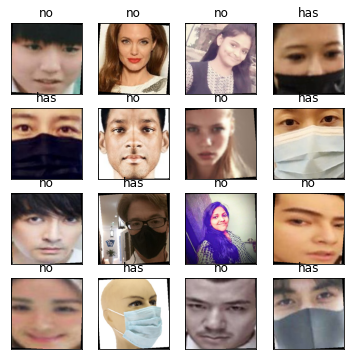

In [5]:
# functions to show an image
def imshow(img):
    # we have to unnormalize it because transforms.Normalize()
    img = img / 2 + 0.5     
    # convert images to numpy for display
    npimg = img.numpy()
    # reshape and plot (because MPL needs channel as the last dimension)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(6, 6))
# display images in the loader
num_images=len(images)
row=4
col=int(num_images/row)
for idx in np.arange(num_images):
    ax = fig.add_subplot(row, col, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    label = labels[idx]
    ax.set_title(classes[labels[idx]])

#### The following section is a CNN model definition

CNN has three different types of layer
1. Convolution (conv): 
2. Pooling (pool)
3. Fully connected (FC) 

**Conv**

Input (in_dim,in_dim_n,in_channels)
a: take inputs (in_dim)  
b: apply filters (filter_size or kernel_size) for each in_channel (3 because of RGB colors), 
c: product out_channels (differnt types of filters, e.g., vertical and horizontal)

conv3d (in_channels, out_channels, filter_size)
    # output_dim = (input_dim - filter_size)+1, assume strip=0 and padding=0
    # general formula to caluculate output_dim= (n+2p-f)/s +1 
        where n is in_dim, p is padding_size, s is strip_size and f is filer_size 

**Pooling (pool)**

MaxPool2d(filter_size, strip_size)

**Fully connected (FC)**
Input: input h*w*channels
out: the number of neurons 


In [6]:
train_on_gpu = torch.cuda.is_available() #check if Cuda is available for training
#Initializing Parameters
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # convolutional layer1
    # in_channels, out_channels, filter_size
    # in_channels = 3 because our image is RGB
    # out_channels = 16 
    self.conv1 = nn.Conv2d(3, 16, 7) # if apply conv1 output_dim=(300-7)+1=294
    # max pooling layer
    self.pool = nn.MaxPool2d(2, 2) # # if appy pool output_dim=(294-2)/2+1=147
    # convolutional layer2
    self.conv2 = nn.Conv2d(16, 32, 7) # if appy conv2  output_dim=(147-7)+1=141 and if apply pool output_dim=(141-2)/2+1=70
    self.dropout = nn.Dropout(0.2)
    # Fully connected layer1
    self.fc1 = nn.Linear(32*70*70, 256)  # input of liner is channels * h * w
    # fully connected layer2
    self.fc2 = nn.Linear(256, 84)
   # fully connected layer3
    self.fc3 = nn.Linear(84, 1)
   # Note we don't need the sigmoid function
   # because BCEWithLogitsLoss will apply Logit function automatically
    
   # feed forward network 
  def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))        
        x = self.pool(F.relu(self.conv2(x)))            
        x = self.dropout(x)
        x = x.view(-1, 32 * 70 * 70) # the size -1 is inferred from other dimensions
        # print(x.size()) a loader of data with each data with (32 * 70 * 70)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        # x = self.softmax(self.fc3(x))
        # x = self.sigmoid(self.fc3(x))
        return x  
   
     
# create Model instance
model = Net()
print(model)
 
# move tensors to GPU if CUDA is available
if(train_on_gpu):
  model.cuda()
  print("CUDA available")

Net(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=156800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)
CUDA available


#### The following section is a training model. The best model will be saved

Each batch has dimention of [batch_size, channels, image_h, iamge_w]
for example, 
    print(data.size())
    torch.Size([16, 3, 300, 300])

After each batch of training, the output dimention is [number of images in the batch, 1], However, the target is a tensor list.
So, we have unsqueeze the target. 

Example:
torch.tensor([1,2]).unsqueeze(1)
tensor([[1],
        [2]])


In [7]:
# initialize tracker for minimum training loss
train_loss_min = np.Inf #  (positive) infinity.

# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model
 
# criterion for binary classificatioin
# nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation.
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.002, momentum= 0.9)

for epoch in range(1, n_epochs+1): 
    # keep track of training and validation loss
    train_loss = 0.0
    model.train()
    
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables, otherwise, the loss will be cumulated
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # compute loss. Need to convert float 
        loss = criterion(output, target.float().unsqueeze(1))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        # loss.item() is a mean for the batch, so we need to * # items in the batch   
        train_loss += loss.item()*data.size(0)
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    # print training/validation statistics 
    # print('Total items: {}'.format(len(train_loader.dataset)))
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    
    # save the best model if validation loss has decreased
    best_model_dir = os.path.join(project_dir, 'model' , 'model.pt')  #contains best model 
    if train_loss <= train_loss_min:
        print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,train_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, best_model_dir)
        train_loss_min = train_loss
    

Epoch: 1 	Training Loss: 0.415125
Train loss decreased (inf --> 0.415125).  Saving model ...
Epoch: 2 	Training Loss: 0.268651
Train loss decreased (0.415125 --> 0.268651).  Saving model ...
Epoch: 3 	Training Loss: 0.218485
Train loss decreased (0.268651 --> 0.218485).  Saving model ...
Epoch: 4 	Training Loss: 0.189175
Train loss decreased (0.218485 --> 0.189175).  Saving model ...
Epoch: 5 	Training Loss: 0.170828
Train loss decreased (0.189175 --> 0.170828).  Saving model ...
Epoch: 6 	Training Loss: 0.147665
Train loss decreased (0.170828 --> 0.147665).  Saving model ...
Epoch: 7 	Training Loss: 0.144036
Train loss decreased (0.147665 --> 0.144036).  Saving model ...
Epoch: 8 	Training Loss: 0.106917
Train loss decreased (0.144036 --> 0.106917).  Saving model ...
Epoch: 9 	Training Loss: 0.116550
Epoch: 10 	Training Loss: 0.095199
Train loss decreased (0.106917 --> 0.095199).  Saving model ...
Epoch: 11 	Training Loss: 0.086896
Train loss decreased (0.095199 --> 0.086896).  Saving

### Load saved model

In [8]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.002, momentum= 0.9)

best_model_dir = os.path.join(project_dir, 'model' , 'model.pt')  #contains best model 

# create Model instance
model = Net()

# move tensors to GPU if CUDA is available
if(train_on_gpu):
  model.cuda()

# load the saved checkpoint
model, optimizer, start_epoch, train_loss_min = load_ckp(best_model_dir, model, optimizer)

print(model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("train_loss_min = ", train_loss_min)
print("train_loss_min = {:.6f}".format(train_loss_min))

Net(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=156800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)
optimizer =  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
start_epoch =  101
train_loss_min =  2.451479407519669e-05
train_loss_min = 0.000025


#### The following section is a test model
loss.item() return the average loss of entire mini-batch
To compute the total loss, we need to multiple number of items in the batch

In [9]:
#Test Model

# track test loss
test_loss = 0.0
# use Confusion Matrix
pred_list = []
target_list=[]
 
model.eval()

for data, target in test_loader:
    if train_on_gpu:     # use GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target.float().unsqueeze(1))
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    pred= (torch.round(torch.sigmoid(output)))  
    
    # just for test confusion matrix
    # Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead
    pred_list.append(pred.detach().numpy()) if not train_on_gpu else pred_list.append(pred.cpu().detach().numpy())
    target_list.append(target.tolist())
  
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy(),1)

 
 # average test loss
print('Total items: {}'.format(len(test_loader.dataset)))
test_loss = test_loss/len(test_loader.dataset)

print('Test Loss: {:.6f}\n'.format(test_loss))
 

# for testing confusion matrix
pred_list = [a.squeeze().tolist() for a in pred_list]  # this is a List Comprehensions
# [[0,0,0,0],[1,1,1,1]]
pred_list= [e for sub in pred_list for e in sub ]  # this is a nested loop

target_list = [e for sub in target_list for e in sub ]

print("\nconfusion_matrix\n", confusion_matrix(target_list, pred_list))
print("\nclassification_report\n",classification_report(target_list, pred_list))

Total items: 258
Test Loss: 0.268208


confusion_matrix
 [[ 86   0]
 [  9 163]]

classification_report
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        86
           1       1.00      0.95      0.97       172

    accuracy                           0.97       258
   macro avg       0.95      0.97      0.96       258
weighted avg       0.97      0.97      0.97       258



#### The following is for manually validation, which manually picks any one image from the validation set

Has Mast


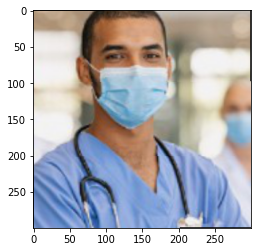

In [10]:
# Test image one by one https://github.com/qubvel/segmentation_models.pytorch/issues/371
import os
validation_dir = data_dir + '/validation/pos'
f=os.path.join(validation_dir ,'Snipaste_2022-01-12_19-04-13.jpg')
img = Image.open(f)

# torch.Size([3, 300, 300])
img_tensor =transformation(img)
# show images. 
imshow(torchvision.utils.make_grid(img_tensor))

# unsqueeze provides the batch dimension: torch.Size([1, 3, 300, 300]) because model's inputs take a batch of images
img_tensor = img_tensor.to('cuda').unsqueeze(0)
model.eval()
output = model(img_tensor)
# convert output probabilities to predicted class
pred= (torch.round(torch.sigmoid(output)))  

#to binarize the output since I had only 1 class

output = (pred.squeeze().detach().numpy().round()) if not train_on_gpu else (pred.squeeze().cpu().detach().numpy().round())
output_str='Has Mast' if  output else 'No Mast'

print(output_str)

#### The following is for random validation, which randomly pick one from the validation set

No Mast


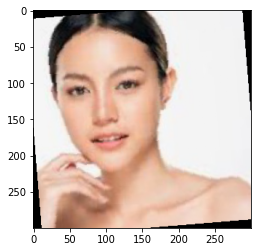

In [11]:
#Validation random
model.eval()

# get some random training images
dataiter = iter(validation_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# we only need the frist one. # unsqueeze provides the batch dimension: torch.Size([1, 3, 224, 224])
img_tensor = images[0].to('cuda').unsqueeze(0)
output = model(img_tensor)
# convert output probabilities to predicted class
pred= (torch.round(torch.sigmoid(output)))  

#to binarize the output since I had only 1 class
output = (pred.squeeze().cpu().detach().numpy().round())
print('Has Mast' if  output else 'No Mast')